# Experimental/mixed approach
In this notebook, we will be testing a network which will use the data from dataset to train itself.

In [1]:
import torch
from torchvision.models import resnet18, resnet50
import model_utils
import plotter
import data_utils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset, Subset
import importlib
import torchvision.transforms as transforms

model_utils.fix_random(42)

## Preparing the data

As we're using a mixed approach, we would need to upscale the CIFAKE images to match the size of the other, more complicated ones. Obviously, we will apply all the other transformations needed to the RVAA dataset.

As the CIFAKE dataset is much more oversampled than the RVAA dataset (120'000 vs 1'000 samples) we need to take in consideration a very small subset of CIFAKE in order to create a properly balanced mixed dataset. In particular, we take about 1200 samples from CIFAKE.

In [12]:
IMG_SIZE = 224

transform_cifake = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),  # Convert to RGB
    transforms.Resize((IMG_SIZE, IMG_SIZE)),                # Resize to IMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


d1 = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="train", transform=transform_cifake)
d2 = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="test", transform=transform_cifake)
cifake_dataset = ConcatDataset([d1, d2])


# Selecting a subset of the CIFAKE datasets
portion_size = int(0.01 * len(cifake_dataset))  # Select 20% of the dataset
indices = list(range(portion_size))
cifake_dataset = Subset(cifake_dataset, indices)

transform_rvaa = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # Convert to RGB
    transforms.Resize(IMG_SIZE),                 # Resize to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square), # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),     # Ensure the final image is IMG_SIZExIMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

rvaa_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform_rvaa)

# the final dataset that's going to be used
merged_dataset = ConcatDataset([cifake_dataset, rvaa_dataset])

In [3]:
LEARNING_RATE = 3e-4
EPOCHS = 20
BATCH_SIZE = 64

In [13]:
train_dataset, val_dataset, test_dataset = data_utils.train_test_split((0.7, 0.15), dataset=merged_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True)

## Model
Since the model that has been giving us great results so far is a ResNet50, we can try and use it again to see if it manages to capture the patterns learned from CIFAKE with the patterns learned from RealVsAiArt.

In [14]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=1)
device = model_utils.get_device()
print(f"using {device} device")
ft_resnet50.to(device)


loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)

dataloaders = (train_dataloader, val_dataloader)

using cuda device


## Training setup
The training is done using 10 epochs and a batch size of 64.
As before, we use a 2-step training method which allows us to train the classification head first and then the feature extractor. As shown in the CIFAKE model, this usually deals pretty good results.

In [15]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, "MixResNet", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=True)

Epoch 1/10
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 78.5%, Avg loss: 0.473389
New best model found! (based on lowest loss)
...and saved.


Epoch 2/10
-------------------------------
Validation Error:
Accuracy: 81.5%, Avg loss: 0.396274
New best model found! (based on lowest loss)
...and saved.


Epoch 3/10
-------------------------------
Validation Error:
Accuracy: 82.8%, Avg loss: 0.364768
New best model found! (based on lowest loss)
...and saved.


Epoch 4/10
-------------------------------
Validation Error:
Accuracy: 82.5%, Avg loss: 0.349185
New best model found! (based on lowest loss)
...and saved.


Epoch 5/10
-------------------------------
Validation Error:
Accuracy: 82.2%, Avg loss: 0.339242
New best model found! (based on lowest loss)
...and saved.


Epoch 6/10
-------------------------------
Validation Error:
Accuracy: 83.7%, Avg loss: 0.329120
New best model found! (based on lowest loss)
...and saved.


Epoch 7/10
-------------------------------
Validation Error:
Accuracy: 85.2%, Avg loss: 0.32140

c:\Users\tekke\Desktop\ethics_project2\model_utils.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_filename))


In [16]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device)

Test Error:
Accuracy: 86.2%, Avg loss: 0.298269


(0.2982693463563919, tensor(0.8620, device='cuda:0'))

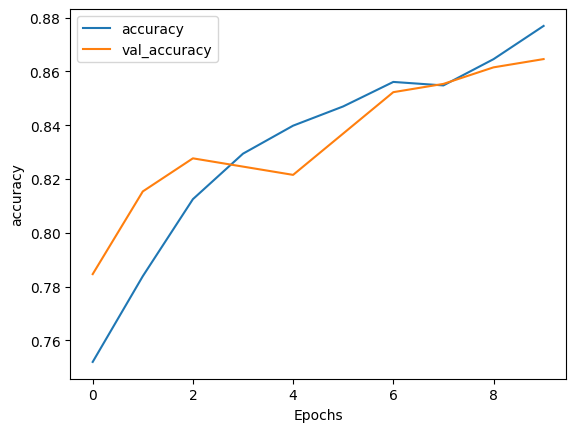

In [17]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts
    plotter.plot_metrics((train_accs, test_accs), "accuracy")

### Fine-tuning step 2
Using a 2-step fine-tuning, we are able to achieve much better performance.

In [19]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)

In [20]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, "MixResNet_beefy", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=True)

Epoch 1/10
-------------------------------
Validation Error:
Accuracy: 84.9%, Avg loss: 0.417047
New best model found! (based on lowest loss)
...and saved.


Epoch 2/10
-------------------------------
Validation Error:
Accuracy: 91.1%, Avg loss: 0.224599
New best model found! (based on lowest loss)
...and saved.


Epoch 3/10
-------------------------------
Validation Error:
Accuracy: 87.4%, Avg loss: 0.638192


Epoch 4/10
-------------------------------
Validation Error:
Accuracy: 85.8%, Avg loss: 0.498619


Epoch 5/10
-------------------------------
Validation Error:
Accuracy: 90.2%, Avg loss: 0.611076


Epoch 6/10
-------------------------------
Validation Error:
Accuracy: 88.3%, Avg loss: 0.463037


Epoch 7/10
-------------------------------
Validation Error:
Accuracy: 84.3%, Avg loss: 0.851145


Epoch 8/10
-------------------------------
Validation Error:
Accuracy: 89.2%, Avg loss: 0.772052


Epoch 9/10
-------------------------------
Validation Error:
Accuracy: 92.3%, Avg loss: 0.

In [21]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device)

Test Error:
Accuracy: 88.7%, Avg loss: 0.218408


(0.21840820709864298, tensor(0.8865, device='cuda:0'))

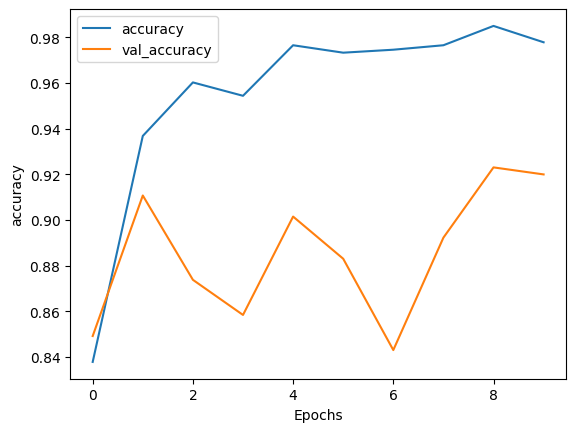

In [22]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts
    plotter.plot_metrics((train_accs, test_accs), "accuracy")